In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, tree, linear_model, metrics


In [3]:
# Проведем инициализацию дата-сета заново, т.к. в процессе обучения сет перебило
water_data = pd.read_csv('data/water_potability.csv')

# Заполняем пропуски
water_data['ph'] = water_data['ph'].fillna(
    water_data.groupby('Potability')['ph'].transform('median'))

water_data['Sulfate'] = water_data['Sulfate'].fillna(
    water_data.groupby('Potability')['Sulfate'].transform('median'))

water_data['Trihalomethanes'] = water_data['Trihalomethanes'].fillna(
    water_data.groupby('Potability')['Trihalomethanes'].transform('median'))

# Стратифицированное разбмение
X, y = water_data.drop('Potability', axis=1), water_data['Potability']

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)

In [6]:
# Пример переобучения модели
model_bad = tree.DecisionTreeClassifier(
    criterion='entropy',
    class_weight='balanced',
    random_state=42
)

model_bad.fit(X_train, y_train)

y_train_pred = model_bad.predict(X_train)
y_valid_pred = model_bad.predict(X_valid)

print(f'F1-score test: {metrics.f1_score(y_train, y_train_pred).round(2)}')
print(f'F1-score test: {metrics.f1_score(y_valid, y_valid_pred).round(2)}')


F1-score test: 1.0
F1-score test: 0.67


In [7]:
# Проверим переобученность через кросс-валидацию
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model_bad,
    X=X,
    y=y,
    cv=skf,
    scoring='f1',
    return_train_score=True
)
display(cv_metrics)


{'fit_time': array([0.04013109, 0.03669095, 0.03854012, 0.03551698, 0.03670478]),
 'score_time': array([0.0025878 , 0.00188017, 0.00174069, 0.00182915, 0.00179696]),
 'test_score': array([0.61445783, 0.68421053, 0.62332696, 0.63276836, 0.70119522]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [9]:
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


---

### Task 4.3

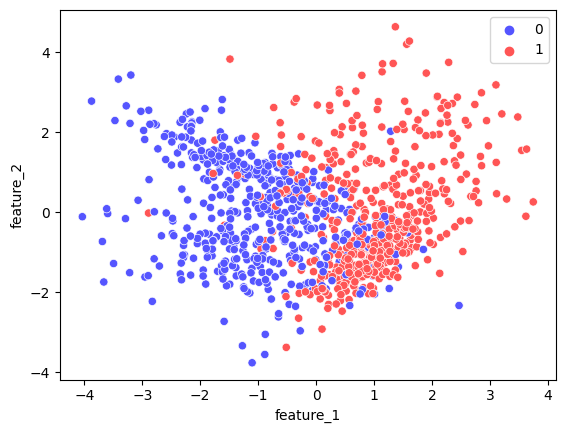

In [19]:
from sklearn import datasets
X_task, y_task = datasets. make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X_task = pd. DataFrame(X_task, columns= ['feature_1', 'feature_2'])
y_task = pd. Series(y_task)
sns.scatterplot(x=X_task['feature_1'], y=X_task['feature_2'], hue=y_task, palette='seismic');

In [21]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_task, y_task, stratify=y_task, train_size=0.3, random_state=42)

model_task = tree.DecisionTreeClassifier(max_depth=10)
model_task.fit(X_train, y_train)

y_test_pred = model_task.predict(X_train)
y_valid_pred = model_task.predict(X_valid)

print(f'Accuracy test: {metrics.accuracy_score(y_test, y_test_pred).round(2)}')
print(f'Accuracy test: {metrics.accuracy_score(y_valid, y_valid_pred).round(2)}')


Accuracy test: 0.98
Accuracy test: 0.82


In [22]:
def plot_probabilities_2d(X, y, model):
    #Генерируем координатную сетку из всех возможных значений для признаков
    #Результат работы функции — два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    #Вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    #Объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    #Предсказываем вероятность для всех точек на координатной сетке
    #Нам нужна только вероятность класса 1
    probs = model.predict_proba(X_net)[:, 1]
    #Переводим столбец из вероятностей в размер координатной сетки
    probs = probs.reshape(xx1.shape)
    #Создаём фигуру и координатную плоскость
    fig, ax = plt.subplots(figsize = (10, 5))
    #Рисуем тепловую карту вероятностей
    contour = ax.contourf(xx1, xx2, probs, 100, cmap='bwr')
    #Рисуем разделяющую плоскость — линию, где вероятность равна 0.5
    bound = ax.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    #Добавляем цветовую панель 
    colorbar = fig.colorbar(contour)
    #Накладываем поверх тепловой карты диаграмму рассеяния
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, palette='seismic', ax=ax)
    #Даём графику название
    ax.set_title('Scatter Plot with Decision Boundary');
    #Смещаем легенду в верхний левый угол вне графика
    ax.legend(bbox_to_anchor=(-0.05, 1))

/Users/kirillkuznecov/opt/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


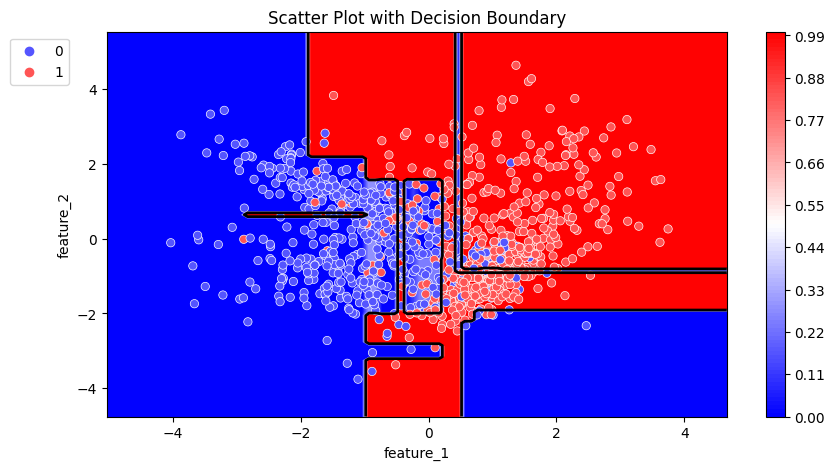

In [28]:
plot_probabilities_2d(X_task, y_task, model_task);

In [32]:
# Для себя проверим переобученность на кроссвалидации
skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model_task,
    X=X_task,
    y=y_task,
    scoring='f1',
    cv=skf,
    return_train_score=True
)

display(cv_metrics)
print(f'Average f1 train: {np.mean(cv_metrics["train_score"]).round(2)}')
print(f'Average f1 validate: {np.mean(cv_metrics["test_score"]).round(2)}')

{'fit_time': array([0.00334191, 0.00264215, 0.0024631 , 0.00250912, 0.00254893]),
 'score_time': array([0.00185895, 0.00149989, 0.00142002, 0.0014379 , 0.00140595]),
 'test_score': array([0.85576923, 0.82539683, 0.8159204 , 0.80203046, 0.84848485]),
 'train_score': array([0.97506234, 0.9761606 , 0.97755611, 0.97391304, 0.96370463])}

Average f1 train: 0.97
Average f1 validate: 0.83


---

### Продолжаем модуль (методика обрезки дерева)

In [47]:
# Уменьшение глубины
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    class_weight='balanced',
    random_state=42
)

skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X,
    y=y,
    cv=skf,
    scoring='f1',
    return_train_score=True
)

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.75
Valid k-fold mean f1: 0.66


In [49]:
# Увеличение количества объектов для образования листа
model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=7,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)

skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=model,
    X=X,
    y=y,
    scoring='f1',
    cv=skf,
    return_train_score=True
)

print(
    f'Train k-fold mean f1 score: {np.mean(cv_metrics["train_score"]).round(2)}')
print(
    f'Train k-fold mean f1 score: {np.mean(cv_metrics["test_score"]).round(2)}')


Train k-fold mean f1 score: 0.74
Train k-fold mean f1 score: 0.66


---

### Task 4.6
Обучите модель дерева решений с глубиной 3 (остальные параметры оставьте по умолчанию) для решения задачи классификации на
тренировочной выборке.
Сделайте предсказания для тренировочной и валидационной выборок и рассчитайте метрику асигасу.
В качестве ответа укажите значение метрики ассигасу на тренировочной и валидационной выборках. Ответ округлите до двух знаков после
точки-разделителя.

In [74]:
from sklearn import datasets
X_task, y_task = datasets.make_classification(
    n_samples=1000, #количество объектов
    n_features=2, #количество признаков
    n_informative=2, #количество информативных признаков
    n_redundant=0, #количество неинформативных признаков
    n_classes=2, #количество классов
    n_clusters_per_class=2, #количество кластеров внутри класса
    random_state=1 #генератор случайных чисел
)
X_task = pd. DataFrame(X_task, columns= ['feature_1', 'feature_2'])
y_task = pd. Series(y_task)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_task, y_task, test_size=0.3, random_state=42)

In [75]:
model_task = tree.DecisionTreeClassifier(max_depth=3)
model_task.fit(X_train, y_train)

y_train_pred = model_task.predict(X_train)
y_valid_pred = model_task.predict(X_valid)

print(f'Accuracy train score: {metrics.accuracy_score(y_train, y_train_pred).round(2)}')
print(f'Accuracy validation score: {metrics.accuracy_score(y_valid, y_valid_pred).round(2)}')


Accuracy train score: 0.88
Accuracy validation score: 0.85


/Users/kirillkuznecov/opt/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


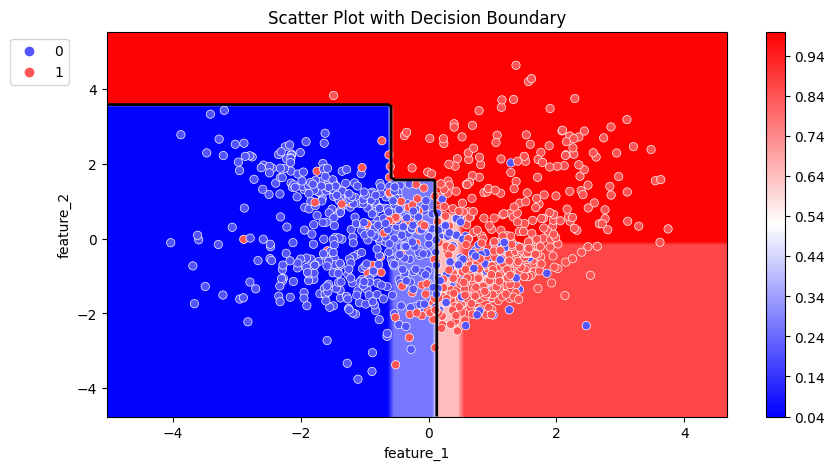

In [76]:
plot_probabilities_2d(X_task, y_task, model_task)